# 1. Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print("Import completed.")

Import completed.


# 2. Load Data

In [2]:
# Set the path to the dataset
file_path = "../datasets/WELFake_Dataset.csv"

df = pd.read_csv(file_path)
df = df.dropna(subset=["title", "text", "label"])
df["title"] = df["title"].astype(str)
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# MAX_SAMPLES = 20000
# df = df[:MAX_SAMPLES] # Limit dataset for testing

# Train-test split
split_idx = int(0.8 * len(df))
train_data = df[:split_idx]
test_data = df[split_idx:]

# 3. Build and Train Linear Regression Classifier

In [9]:
# Build the model
model = make_pipeline(TfidfVectorizer(), LinearSVC(random_state=42))

# Train the model
model.fit(train_data['title']+' '+train_data['text'], train_data['label'])

# Predict test data
predicted_categories = model.predict(test_data['title']+' '+test_data['text'])

# 4. Compute and Display Metrics

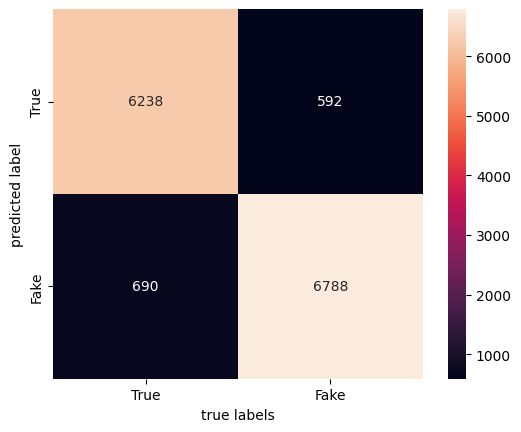

Accuracy: 0.9103997763488957
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6928
           1       0.91      0.92      0.91      7380

    accuracy                           0.91     14308
   macro avg       0.91      0.91      0.91     14308
weighted avg       0.91      0.91      0.91     14308



In [8]:
matrix = confusion_matrix(test_data['label'], predicted_categories)

labels = sorted(df['label'].unique())

sns.heatmap(matrix.T,
            square = True,
            annot=True,
            fmt = "d",
            xticklabels = ["True", "Fake"],
            yticklabels = ["True", "Fake"])

plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

print("Accuracy: {}".format(accuracy_score(test_data['label'], predicted_categories)))

print(classification_report(test_data['label'], predicted_categories))